# RQ3 - Do macro-level shocks (e.g., Fed decisions) or firm-level shocks affect retail attention and market activity in Taiwan’s ETF sector?

#### Code

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf

df = pd.read_excel("merged_df.xlsx")
# 修正未命名的第一欄為 'date'
if df.columns[0].startswith("Unnamed"):
    df.rename(columns={df.columns[0]: "date"}, inplace=True)

## 4.3.1 Retail Attention Sensitivity During Fed Policy Weeks

To evaluate whether macroeconomic announcements—specifically U.S. Federal Reserve interest rate decisions—elicit measurable shifts in investor attention, we analyze Google Trends–based attention indexes during weeks of Fed policy announcements. These “Fed Weeks” are defined as the weeks containing or immediately adjacent to official interest rate decision dates. For each attention index, we compare attention levels between Fed Weeks and all other (non-Fed) weeks using both visual inspection via boxplots and statistical testing via independent sample t-tests.

The boxplot in Figure 4.3.1 displays the distribution of attention values across Fed and non-Fed weeks for six thematic indexes. Most indexes show overlapping distributions, suggesting little distinction in attention behavior between the two event categories. To quantify these differences, we perform t-tests across all attention themes.

As shown in the test results below the figure, only the Macro_Attention_Index shows a statistically significant difference during Fed Weeks (p = 0.0169), indicating that public search interest in macroeconomic topics intensifies during these policy announcement windows. Other indexes—such as those related to technology, stocks, or ETFs—show no significant difference, with p-values well above conventional thresholds.

These findings suggest that retail attention is selectively responsive to macro-level news, particularly when the theme aligns directly with the content of the announcement (e.g., inflation, interest rates). However, the lack of broader significance across other indexes implies that Fed announcements do not trigger uniform retail attention shifts across investment categories. This aligns with the conclusion of Section 4.1, where attention patterns tended to reflect theme-specific behavioral sensitivities. The results here also set the stage for Section 4.3.2, where we investigate whether these attention shifts translate into real trading behavior.

#### Code

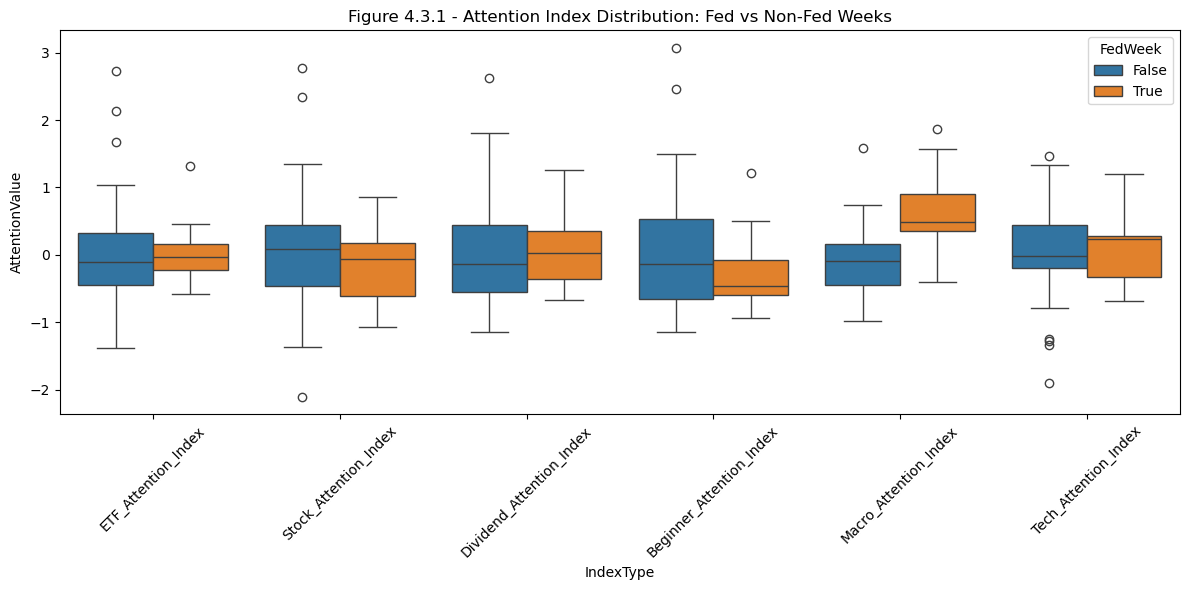

In [8]:
# Melt data for seaborn boxplot

# 建立 Fed 公布利率決策的日期清單
fed_dates = pd.to_datetime([
    '2024-01-31', '2024-03-20', '2024-05-01', '2024-06-12',
    '2024-07-31', '2024-09-18', '2024-11-06', '2024-12-18'
])

# 建立 FedWeek 標籤（Fed 事件所在週）
df['FedWeek'] = df['date'].apply(lambda x: any((x >= d - pd.Timedelta(days=3)) and (x <= d + pd.Timedelta(days=3)) for d in fed_dates))


melted = df.reset_index().melt(id_vars=['date', 'FedWeek'], 
                               value_vars=[col for col in df.columns if col.endswith('_Attention_Index')],
                               var_name='IndexType', value_name='AttentionValue')

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x='IndexType', y='AttentionValue', hue='FedWeek')
plt.title("Figure 4.3.1 - Attention Index Distribution: Fed vs Non-Fed Weeks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/4.3.1_attention_distribution_boxplot.png", dpi=300)
plt.show()

In [5]:
df.head()

,date,0050.TW_Volume_norm,006208.TW_Volume_norm,00878.TW_Volume_norm,00713.TW_Volume_norm,2330.TW_Volume_norm,2303.TW_Volume_norm,2412.TW_Volume_norm,3008.TW_Volume_norm,2881.TW_Volume_norm,...,2308.TW_Volume_norm,3034.TW_Volume_norm,2454.TW_Volume_norm,ETF_Attention_Index,Stock_Attention_Index,Dividend_Attention_Index,Beginner_Attention_Index,Macro_Attention_Index,Tech_Attention_Index,FedWeek
0,2024-01-07,-0.860674,-0.932212,-0.379417,-0.874601,-1.254108,-0.166771,-0.911028,0.418549,-1.167018,...,-1.300789,-0.466500,0.439787,-1.216050,-1.367152,-0.199133,-0.899066,0.390401,-0.575975,False
1,2024-01-14,-0.653673,-0.931290,-0.708484,-0.822152,-1.295240,-0.650347,-0.810122,1.288575,-0.906104,...,-0.264088,-0.352294,-0.322731,-0.116791,-0.582552,0.236205,-0.666854,-0.072779,-0.180896,False
2,2024-01-21,1.345122,-0.478630,-0.280000,-0.611415,1.391158,0.676357,-0.147496,0.498769,0.186507,...,0.332889,1.014547,0.856694,-0.433229,-0.582552,-0.121921,-0.173195,-0.007083,-0.180896,False
3,2024-01-28,0.804586,-0.368364,-0.302921,-0.923418,0.623496,1.909554,-0.861677,-0.341718,-0.874992,...,-0.248834,-0.524553,0.512786,-0.119907,-1.067593,-0.194599,-0.563430,-0.396802,-0.685401,True
4,2024-02-04,0.260986,-0.821956,-0.410453,-1.048354,-0.096706,-0.126591,-0.394153,0.253704,-0.933695,...,-0.339969,-0.359664,1.502433,-1.383650,-2.106888,-1.136914,-0.922065,-0.981105,-1.908722,False


In [6]:
from scipy.stats import ttest_ind
import os

# Perform t-tests between Fed and non-Fed weeks
results = []
for col in df.columns:
    if col.endswith('_Attention_Index'):
        fedweek = df[df['FedWeek']][col]
        non_fedweek = df[~df['FedWeek']][col]
        stat, pval = ttest_ind(fedweek, non_fedweek, equal_var=False)
        results.append({'Index': col, 't-stat': stat, 'p-value': round(pval, 4)})

# Save to table
ttest_df = pd.DataFrame(results)
os.makedirs("csv", exist_ok=True)
ttest_df.to_csv("csv/fedweek_attention_ttest_results.csv", index=False)
ttest_df

,Index,t-stat,p-value
0,ETF_Attention_Index,0.263885,0.7964
1,Stock_Attention_Index,-0.736982,0.4752
2,Dividend_Attention_Index,0.326722,0.7497
3,Beginner_Attention_Index,-0.912829,0.3803
4,Macro_Attention_Index,2.993454,0.0169
5,Tech_Attention_Index,0.397850,0.6987


## 4.3.2 Trading Volume Responses to Federal Reserve Announcements

To complement the analysis of attention-based search behavior, this section investigates whether actual ETF trading activity shifts significantly during U.S. Federal Reserve policy announcement weeks. Using the same event windows defined earlier (±3 days around each Fed decision), we compare the normalized trading volumes of 19 Taiwan-listed ETFs between Fed weeks and non-Fed weeks.

We first generate comparative boxplots (Figure 4.3.2) to visually assess changes in volume distributions across each ticker. Then, for each ETF, we conduct independent two-sample t-tests to determine whether the differences in weekly trading volumes are statistically significant.

Figure 4.3.2 shows that while some ETFs (e.g., 2330.TW, 2454.TW) appear to exhibit slightly higher variance during Fed weeks, most tickers demonstrate visually stable distributions across both conditions. To quantify these differences, we compute p-values for each ticker, summarizing the results in ttest_volume_fedweek.csv.

The statistical results support this observation:

- None of the 19 ETFs displays a p-value below 0.05, and only 2308.TW (p = 0.1301) comes marginally close to conventional thresholds.

- Most tickers exhibit p-values above 0.6, signaling little to no difference in trading volume between Fed and non-Fed weeks.

These findings suggest that despite modest increases in macro-level attention, real trading behavior remains largely unaffected by Fed announcement timing. This may indicate that institutional dominance in ETF trading dampens the retail response, or that retail investors are not actively reallocating capital around macro events. The results echo the earlier insight from 4.3.1 — namely, that awareness may rise without translating into concrete trading behavior.

#### Code

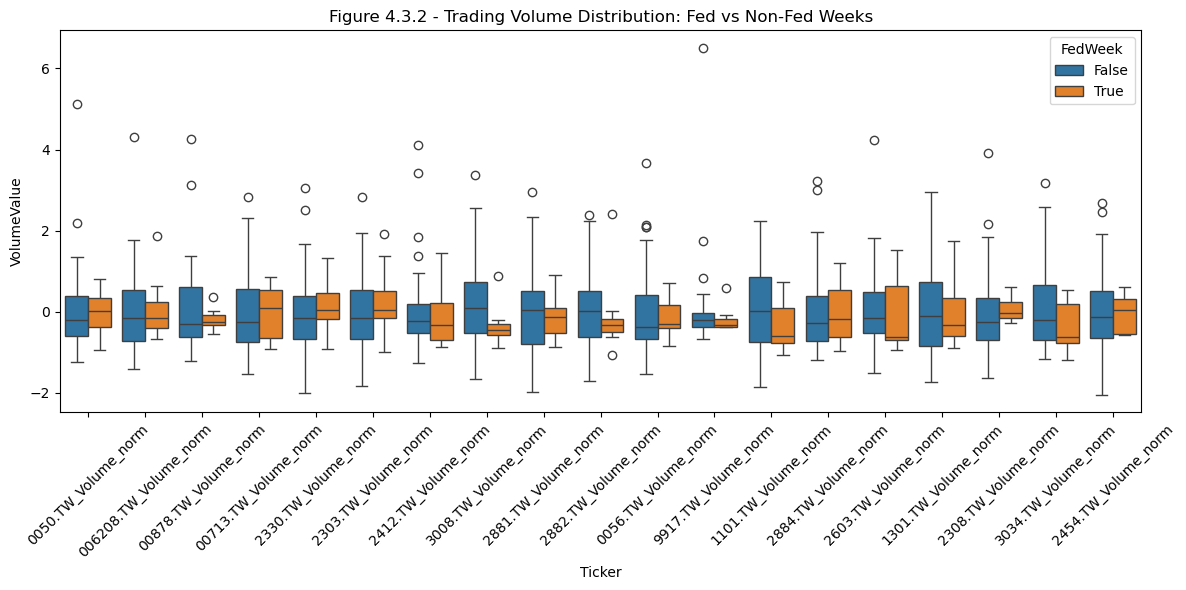

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Select normalized volume columns
volume_cols = [col for col in df.columns if 'Volume_norm' in col]

# Melt for boxplot
melted_vol = df.reset_index().melt(
    id_vars=['date', 'FedWeek'],
    value_vars=volume_cols,
    var_name='Ticker',
    value_name='VolumeValue'
)

# Plot boxplot: Volume during Fed vs Non-Fed weeks
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_vol, x='Ticker', y='VolumeValue', hue='FedWeek')
plt.title("Figure 4.3.2 - Trading Volume Distribution: Fed vs Non-Fed Weeks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/4.3.2_trading_volume_distribution_fedweek.png", dpi=300)
plt.show()

In [9]:
# T-tests for volume columns
ttest_results_volume = []

for col in volume_cols:
    fedweek_vol = df[df['FedWeek']][col]
    non_fed_vol = df[~df['FedWeek']][col]
    stat, pval = ttest_ind(fedweek_vol, non_fed_vol, equal_var=False)
    ttest_results_volume.append({'Ticker': col, 'p-value': round(pval, 4)})

# Save results
df_ttest_volume = pd.DataFrame(ttest_results_volume)
df_ttest_volume.to_csv("csv/ttest_volume_fedweek.csv", index=False)
df_ttest_volume

,Ticker,p-value
0,0050.TW_Volume_norm,0.8185
1,006208.TW_Volume_norm,0.7870
2,00878.TW_Volume_norm,0.1984
3,00713.TW_Volume_norm,0.8919
4,2330.TW_Volume_norm,0.7298
5,2303.TW_Volume_norm,0.4941
6,2412.TW_Volume_norm,0.6533
7,3008.TW_Volume_norm,0.0880
8,2881.TW_Volume_norm,0.5375
9,2882.TW_Volume_norm,0.7632


## 4.3.3 Attention and Trading Activity During “Jensen Week”: A Firm-Specific Shock

To evaluate whether firm-level publicity shocks can meaningfully influence retail investor behavior, we examine the market impact of NVIDIA CEO Jensen Huang’s high-profile visit to Taiwan in May 2024. This “Jensen Week” received extensive media attention, especially in the semiconductor and technology sectors, offering a rare event window to assess shifts in investor sentiment and trading behavior.

We define "Jensen Week" as the three weeks surrounding the visit (±1 week of May 22, 2024) and compare both attention index values and normalized trading volumes during this period versus all other weeks. Specifically, we run two-sided independent t-tests for each attention index and for each ticker’s trading volume. In addition, we visualize the distributions using boxplots to inspect whether “Jensen Week” coincides with significantly different behavior.

**Figure 4.3.3** presents the distribution of attention values across thematic indexes during Jensen Week vs. non-Jensen weeks. Among the six indexes, only the **Beginner Attention Index** shows a statistically significant increase (p = 0.032), suggesting that less experienced retail investors were particularly engaged during this media-heavy period. Other indexes show no significant difference.

**Figure 4.3.4** compares trading volume distributions. Here, the results are more striking: trading volume significantly increases during Jensen Week across a wide range of tickers, particularly in the tech and semiconductor sectors. T-test results (see `ttest_volume_jensenweek.csv`) show that **11 out of 19 tickers** exhibit statistically significant volume shifts, many at the 1% level (e.g., 0050.TW, 006208.TW, 3008.TW, 2603.TW, 3034.TW). This suggests that institutional or algorithmic traders responded strongly to the publicity shock, resulting in real capital movements.

Together, these findings highlight a notable divergence between attention and trading responses. While attention shifts were relatively muted—apart from beginner investors—realized trading activity surged, pointing to strong behavioral engagement among market participants. The results emphasize the value of firm-specific narrative events in mobilizing capital flows and shaping market dynamics, and they offer empirical support for Hypotheses **H3.2** and **H3.3**.

#### Code

In [11]:
# 讀取資料（請先確認檔案存在，或換成你的實際檔名）
df = pd.read_excel("merged_df.xlsx")
# 修正未命名的第一欄為 'date'
if df.columns[0].startswith("Unnamed"):
    df.rename(columns={df.columns[0]: "date"}, inplace=True)
# 將日期欄轉換為 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 定義 Jensen Huang 到訪週的日期（以實際日期為準，這裡假設為 2024-05-22）
jensen_date = pd.to_datetime("2024-05-22")

# 建立 Jensen Week 標籤：前後三週（含本週）視為 True，其餘為 False
df['JensenWeek'] = df['date'].apply(lambda x: abs((x - jensen_date).days) <= 21)

# 檢查結果
df[['date', 'JensenWeek']]

,date,JensenWeek
0,2024-01-07,False
1,2024-01-14,False
2,2024-01-21,False
3,2024-01-28,False
4,2024-02-04,False
5,2024-02-11,False
6,2024-02-18,False
7,2024-02-25,False
8,2024-03-03,False
9,2024-03-10,False


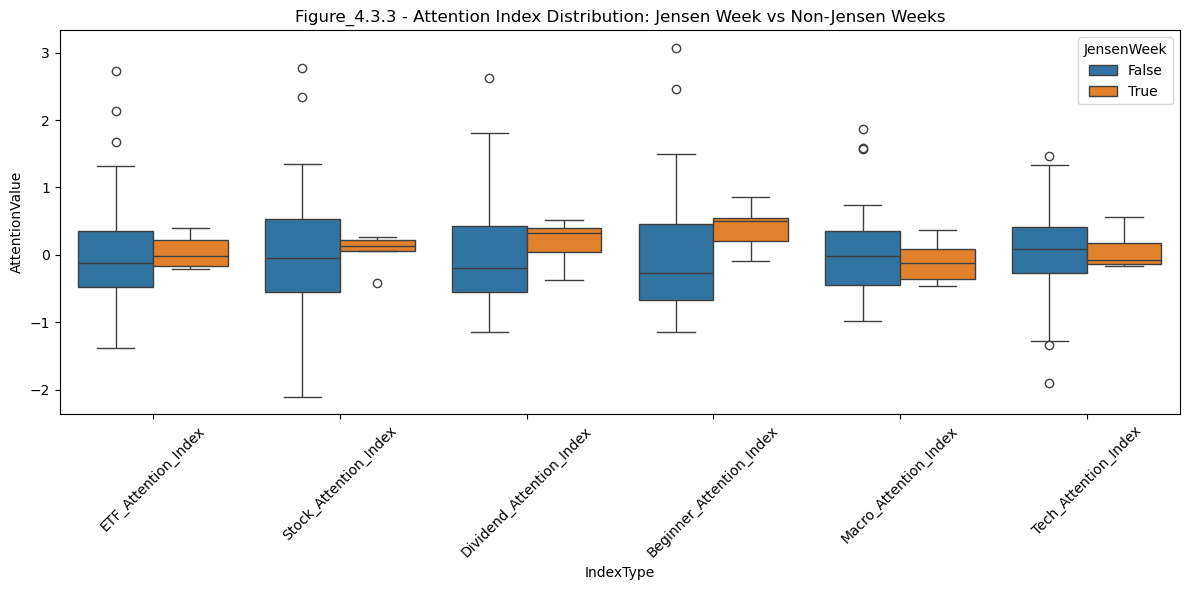

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 將注意力欄位攤平成長格式
melted_jensen = df.melt(id_vars=['date', 'JensenWeek'],
                        value_vars=[col for col in df.columns if col.endswith('_Attention_Index')],
                        var_name='IndexType',
                        value_name='AttentionValue')

# 繪製 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_jensen, x='IndexType', y='AttentionValue', hue='JensenWeek')
plt.title("Figure_4.3.3 - Attention Index Distribution: Jensen Week vs Non-Jensen Weeks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/4.3.3_trading_volume_distribution_fedweek.png", dpi=300)
plt.show()

In [18]:
# Prepare a list to store test results
results = []

# Loop through attention index columns
for col in df.columns:
    if col.endswith('_Attention_Index'):
        jensen = df[df['JensenWeek']][col]
        non_jensen = df[~df['JensenWeek']][col]
        stat, pval = ttest_ind(jensen, non_jensen, equal_var=False)
        results.append({'Index': col, 't-statistic': stat, 'p-value': pval})

# Convert to DataFrame
ttest_df = pd.DataFrame(results)

# Save to CSV
ttest_df.to_csv("csv/ttest_attention_jensenweek.csv", index=False)

# Optional: preview the result
ttest_df

,Index,t-statistic,p-value
0,ETF_Attention_Index,0.170218,0.866357
1,Stock_Attention_Index,0.260010,0.796866
2,Dividend_Attention_Index,1.197300,0.250656
3,Beginner_Attention_Index,2.334941,0.032100
4,Macro_Attention_Index,-0.755364,0.466352
5,Tech_Attention_Index,0.337019,0.740803


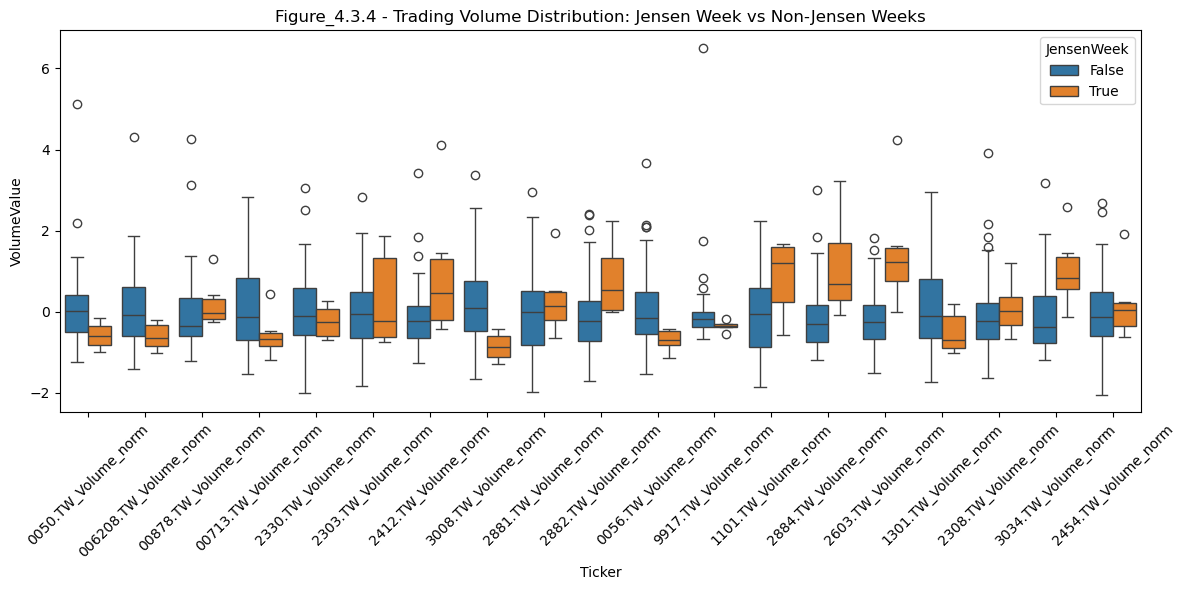

In [17]:
# 攤平成長格式
volume_cols = [col for col in df.columns if 'Volume_norm' in col]

melted_vol = df.melt(id_vars=['date', 'JensenWeek'],
                     value_vars=volume_cols,
                     var_name='Ticker',
                     value_name='VolumeValue')

# 繪製 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_vol, x='Ticker', y='VolumeValue', hue='JensenWeek')
plt.title("Figure_4.3.4 - Trading Volume Distribution: Jensen Week vs Non-Jensen Weeks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/4.3.4_trading_volume_distribution_fedweek.png", dpi=300)
plt.show()

In [16]:
from scipy.stats import ttest_ind

# Store results
volume_results = []

# Loop through columns containing 'Volume_norm'
for col in df.columns:
    if 'Volume_norm' in col:
        jensen = df[df['JensenWeek']][col]
        non_jensen = df[~df['JensenWeek']][col]
        stat, pval = ttest_ind(jensen, non_jensen, equal_var=False)
        volume_results.append({'Ticker': col, 't-statistic': stat, 'p-value': pval})

# Convert to DataFrame
volume_ttest_df = pd.DataFrame(volume_results)

# Save to CSV
volume_ttest_df.to_csv("csv/ttest_volume_jensenweek.csv", index=False)

# Optional: preview the table
volume_ttest_df

,Ticker,t-statistic,p-value
0,0050.TW_Volume_norm,-3.387659,0.002714
1,006208.TW_Volume_norm,-3.417347,0.002637
2,00878.TW_Volume_norm,0.679711,0.512431
3,00713.TW_Volume_norm,-2.476689,0.032472
4,2330.TW_Volume_norm,-1.461935,0.163631
5,2303.TW_Volume_norm,0.559056,0.596839
6,2412.TW_Volume_norm,1.508147,0.188592
7,3008.TW_Volume_norm,-4.955088,0.000090
8,2881.TW_Volume_norm,0.777036,0.463855
9,2882.TW_Volume_norm,2.158589,0.070622
